# PyTorch: CIFAR10 ResNet (Better Implimentation)

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
if not os.path.isfile('dataset/cifar10.tgz'):
    dataset_url = 'http://files.fast.ai/data/cifar10.tgz'
    download_url(dataset_url, 'dataset/')
else:
    print('Data already downloaded.')

if not os.path.isdir('dataset/cifar10'):
    with tarfile.open('dataset/cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='dataset/')
else:
    print('Data already extracted.')

data_dir = 'dataset/cifar10/'
print(os.listdir(data_dir))

classes = os.listdir(data_dir + 'train')
print(classes)

Data already downloaded.
Data already extracted.
['labels.txt', 'models', 'test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
means, std = ([0.4913996786151959, 0.4821584083946092, 0.4465309144454658], [0.2470322324632819, 0.24348512800005603, 0.26158784172796434]) # Check pytorch_images_resnet.ipynb cell 3

In [4]:
train_tfms = tt.Compose([
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(means, std, inplace=True)
])

val_tfms = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(means, std)
])

In [5]:
train_ds = ImageFolder(data_dir + 'train', train_tfms)
val_ds = ImageFolder(data_dir + 'test', val_tfms)

In [6]:
train_batch = 128
val_batch = 64

In [7]:
train_loader = DataLoader(train_ds, batch_size=train_batch, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=val_batch, shuffle=True, pin_memory=True, num_workers=0)

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


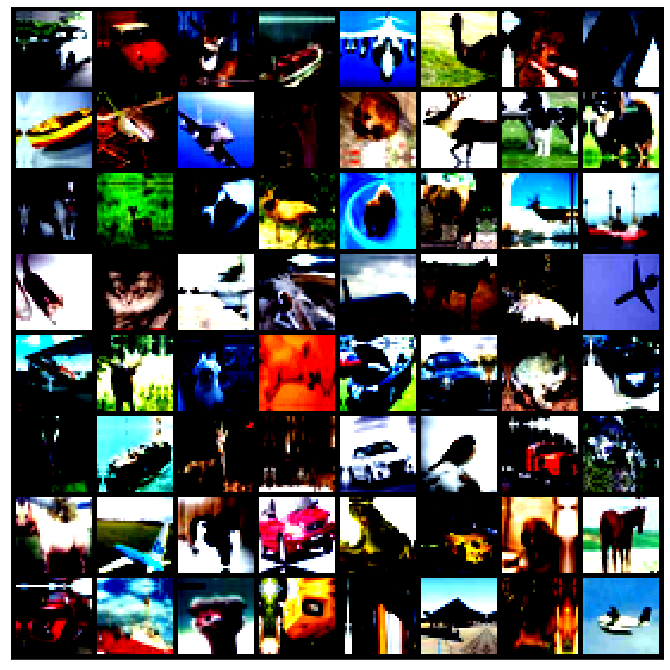

In [9]:
show_batch(train_loader)

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [13]:
class SimpleResidualBlock (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [14]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_loader:
    out = simple_resnet(images)
    print(out.shape)
    break

torch.Size([128, 3, 32, 32])


In [15]:
del simple_resnet, images, labels
torch.cuda.empty_cache()

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase (nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.5f}, val_loss: {:.5f}, val_acc: {:.5f}".format(
            epoch + 1, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

![ResNet9 Architecture](https://raw.githubusercontent.com/lambdal/cifar10-fast/master/net.svg)

In [17]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # prep
        self.conv1 = conv_block(in_channels, 64)
        
        # layer 1 start
        self.conv2 = conv_block(64, 128, pool=True)
        # residual start
        self.res1 = nn.Sequential(
            # res 1
            conv_block(128, 128),
            # res 2
            conv_block(128, 128)
        )
        # residual end
        # layer 1 end
        
        # layer 2 start
        self.conv3 = conv_block(128, 256, pool=True)
        # layer 2 end
        
        # layer 3 start
        self.conv4 = conv_block(256, 512, pool=True)
        # residual start
        self.res2 = nn.Sequential(
            # res 1
            conv_block(512, 512),
            # res 2
            conv_block(512, 512)
        )
        # residual end
        # layer 3 end
        
        # classifier
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [18]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3017189502716064, 'val_acc': 0.10131369531154633}]

In [21]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [22]:
%%time
history += fit_one_cycle(
    epochs,
    max_lr,
    model,
    train_loader,
    val_loader,
    grad_clip=grad_clip,
    weight_decay=weight_decay,
    opt_func=opt_func
)

Epoch [1], last_lr: 0.00104, train_loss: 1.18360, val_loss: 0.85081, val_acc: 0.70521
Epoch [2], last_lr: 0.00280, train_loss: 0.80381, val_loss: 0.83920, val_acc: 0.72840
Epoch [3], last_lr: 0.00520, train_loss: 0.78158, val_loss: 0.80871, val_acc: 0.72671
Epoch [4], last_lr: 0.00760, train_loss: 0.73647, val_loss: 0.85980, val_acc: 0.72134
Epoch [5], last_lr: 0.00936, train_loss: 0.66858, val_loss: 0.73750, val_acc: 0.76781
Epoch [6], last_lr: 0.01000, train_loss: 0.60118, val_loss: 0.56991, val_acc: 0.80703
Epoch [7], last_lr: 0.00987, train_loss: 0.57070, val_loss: 0.77988, val_acc: 0.74622
Epoch [8], last_lr: 0.00950, train_loss: 0.56575, val_loss: 0.70101, val_acc: 0.76861
Epoch [9], last_lr: 0.00891, train_loss: 0.55400, val_loss: 0.71577, val_acc: 0.76423
Epoch [10], last_lr: 0.00812, train_loss: 0.53037, val_loss: 0.54670, val_acc: 0.81588
Epoch [11], last_lr: 0.00717, train_loss: 0.50766, val_loss: 0.69157, val_acc: 0.76931
Epoch [12], last_lr: 0.00611, train_loss: 0.49108, v

In [23]:
train_time = '18:53'

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

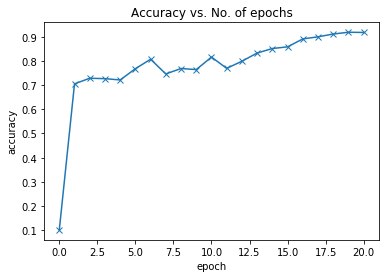

In [25]:
plot_accuracies(history)

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

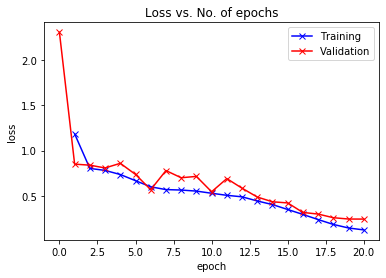

In [27]:
plot_losses(history)

In [28]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

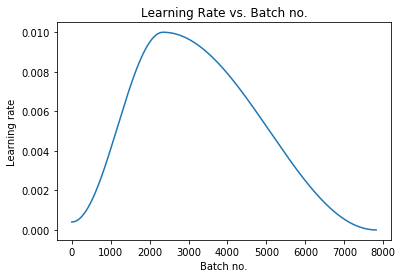

In [29]:
plot_lrs(history)